In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### okay, we will perform experiments for section 5
### first, we will start with byte sizes.....

### basically what we want to show is the correlation between byte size and label change....
### the way we will perform this experiment is, let's say we sampled the images 



import sys
sys.path.append('/nethome/jbang36/eko')


In [3]:
### let's run the experiment and get the results
video_names = ['cherry960', 'ua_detra960', 'dashcam960', 'jackson']
video_name = 'cherry960'
category = 'car'

from eko_paper2022.motivation.main import *

images = load_dataset(video_name)

12-01-2022 14:25:02 [info:049]INFO : meta data of the video /srv/data/jbang36/video_data/cherry960/video.mp4 is (100000, 540, 960, 3)
meta data of the video /srv/data/jbang36/video_data/cherry960/video.mp4 is (100000, 540, 960, 3)
100%|██████████| 100000/100000 [01:45<00:00, 947.61it/s]


In [4]:
### need to load the labels and the byte sizes...
### we can easily compute the label difference and byte sizes.


from eko_paper2022.motivation.main import execute_ekoalt
from eko_paper2022.experiments.main import *


eko = execute_ekoalt(images, video_name, nb_buckets = 70000)

from eko_paper2022.experiments.main import *


query = get_labels(eko)
a = query.y_pred
b = query.y_true
gt_retrieval = []
for bb in b:
    gt_retrieval.append(float(bb))
gt_retrieval = np.array(gt_retrieval)

index initializing....
number of training instances:  1
mining complete!
training complete!
inferring complete!
0.8 70000
rep indices stats 70000 100000
100000 70000
bucketing complete!


Target DNN Invocations:   0%|          | 0/100000 [00:00<?, ?it/s]

Propagation:   0%|          | 0/100000 [00:00<?, ?it/s]

In [5]:
gt_retrieval

array([          0,           0,           0, ...,           1,           1,           1])

In [6]:
sum(gt_retrieval) / len(gt_retrieval)

0.36014

In [7]:
#### now we just need to get the byte sizes of all the frames in the video


from src.iframes.pyav_utils import PYAV_wrapper


base = '/srv/data/jbang36/video_data'
directory = os.path.join(base, video_name, 'video.mp4')
pyav = PYAV_wrapper(directory)



In [8]:
video_bytes = pyav.get_bytes()

100000
returning 100000 frames in 0.4120339937508106 seconds


In [9]:
video_bytes

[25576,
 10991,
 2088,
 671,
 637,
 1842,
 1018,
 824,
 1035,
 2692,
 1312,
 726,
 41554,
 1577,
 760,
 1078,
 477,
 712,
 461,
 388,
 454,
 627,
 415,
 523,
 41694,
 819,
 544,
 469,
 450,
 386,
 404,
 338,
 368,
 664,
 469,
 379,
 41779,
 995,
 421,
 336,
 360,
 584,
 384,
 332,
 355,
 389,
 283,
 294,
 41836,
 893,
 469,
 481,
 368,
 471,
 356,
 308,
 353,
 545,
 463,
 379,
 41853,
 1189,
 511,
 335,
 455,
 489,
 365,
 378,
 415,
 379,
 333,
 342,
 41885,
 1269,
 529,
 442,
 424,
 628,
 398,
 353,
 471,
 339,
 333,
 290,
 41934,
 848,
 375,
 382,
 360,
 360,
 297,
 273,
 333,
 339,
 322,
 279,
 41934,
 873,
 469,
 278,
 293,
 380,
 300,
 299,
 299,
 288,
 291,
 313,
 41936,
 935,
 407,
 306,
 376,
 378,
 439,
 396,
 399,
 416,
 378,
 331,
 41958,
 1166,
 506,
 420,
 355,
 311,
 387,
 636,
 458,
 345,
 400,
 428,
 41993,
 925,
 450,
 452,
 352,
 305,
 342,
 363,
 350,
 348,
 318,
 429,
 41994,
 1014,
 387,
 658,
 435,
 501,
 321,
 487,
 295,
 386,
 326,
 384,
 41993,
 976,
 462,
 536

In [10]:
### compute label change.... for this since we are doing moving objects, let's just say that if 0->1 = 1, 1->0 = 1, 1->1 = 1. Only 0->0 = 0

gt_retrieval


array([          0,           0,           0, ...,           1,           1,           1])

In [11]:
1 | 0, 0 | 1, 1 | 1, 0 | 0

(1, 1, 1, 0)

In [12]:
def convert_gt(gt_retrieval):
    arr = [0]
    
    for i in range(len(gt_retrieval) - 1):
        ### what happens to the first? -> always 0
        first = int(gt_retrieval[i])
        second = int(gt_retrieval[i+1])
        if first | second: arr.append(1)
        else: arr.append(0)
        
    return np.array(arr)
        
converted_gt = convert_gt(gt_retrieval)


In [13]:
len(converted_gt), len(video_bytes)

(100000, 100000)

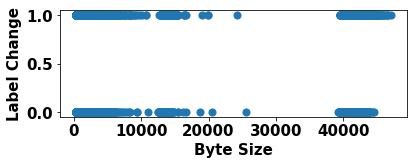

In [17]:
##### okay, now we just need to draw the scatter plot

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)

plt.figure(figsize = (6, 2.5))

plt.ylabel('Label Change', weight = 'bold', size = 15)
plt.xlabel('Byte Size', weight = 'bold', size = 15)
plt.xticks([0, 10000, 20000, 30000, 40000])
plt.scatter(video_bytes, converted_gt, label = 'I-frames', s=50)
plt.tight_layout()

plt.savefig(f'plots/section5-bytes-{video_name}.png')



In [15]:
#### compute the correlation factor..
#### pearson correlation

from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(video_bytes, converted_gt)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.014


In [ ]:



##### now, what we will do is perform the same thing with pixel difference....



In [16]:
###

images.shape

(100000, 540, 960, 3)

In [17]:
images_down = images[:,::54,::96,:]

In [18]:
images_down.shape

(100000, 10, 10, 3)

In [21]:
#### downsize the images and compute the pixel difference

def compute_pixel_diff(images_down):
    diff = [0]
    
    for i in range(len(images_down) - 1):
        first = images_down[i]
        second = images_down[i+1]
        diff.append(np.linalg.norm(first - second))
        
    return np.array(diff)
    
    
    
pixel_diff = compute_pixel_diff(images_down) 


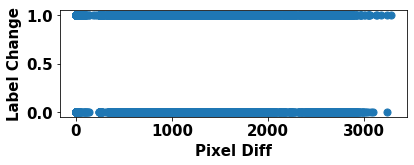

In [24]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)

plt.figure(figsize = (6, 2.5))

plt.ylabel('Label Change', weight = 'bold', size = 15)
plt.xlabel('Pixel Diff', weight = 'bold', size = 15)
#plt.xticks([0, 100000, 200000])
plt.scatter(pixel_diff, converted_gt, label = 'I-frames', s=50)
plt.tight_layout()

plt.savefig(f'plots/section5-pixel-{video_name}.png')



In [25]:
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(pixel_diff, converted_gt)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.134


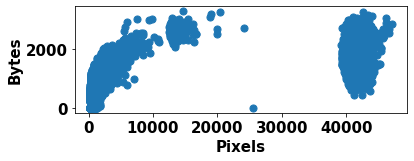

In [27]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)

plt.figure(figsize = (6, 2.5))

plt.ylabel('Bytes', weight = 'bold', size = 15)
plt.xlabel('Pixels', weight = 'bold', size = 15)
#plt.xticks([0, 100000, 200000])
plt.scatter(video_bytes, pixel_diff, label = 'I-frames', s=50)
plt.tight_layout()

#plt.savefig(f'plots/section5-pixel-{video_name}.png')

In [28]:
#### okay, finally we see if there is a correlation between resnet features and label differences...
#### first, we will have to run resnet18 to get the features on the image frames. 

### load the npy data


directory = '/srv/data/jbang36/tasti_data/cache/tasti_triplet/embeddings_cherry960.npy'

import numpy as np


resnet_features = np.load(directory)


In [29]:
resnet_features.shape

(100000, 512)

In [30]:
### okay, now compute the resnet feature difference and map it

resnet_diff = compute_pixel_diff(resnet_features)

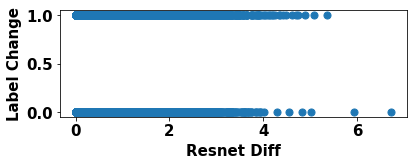

In [34]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)

plt.figure(figsize = (6, 2.5))

plt.ylabel('Label Change', weight = 'bold', size = 15)
plt.xlabel('Resnet Diff', weight = 'bold', size = 15)
#plt.xticks([0, 100000, 200000])
plt.scatter(resnet_diff, converted_gt, label = 'I-frames', s=50)
plt.tight_layout()

plt.savefig(f'plots/section5-resnet-{video_name}.png')



In [32]:
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(resnet_diff, converted_gt)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.274
